<a href="https://www.kaggle.com/code/werakaggle/time-series-forecasting-methods-part-ii-xgboost?scriptVersionId=119680950" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Time series forecasting methods part II

## Extreme Gradient Boosting 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt

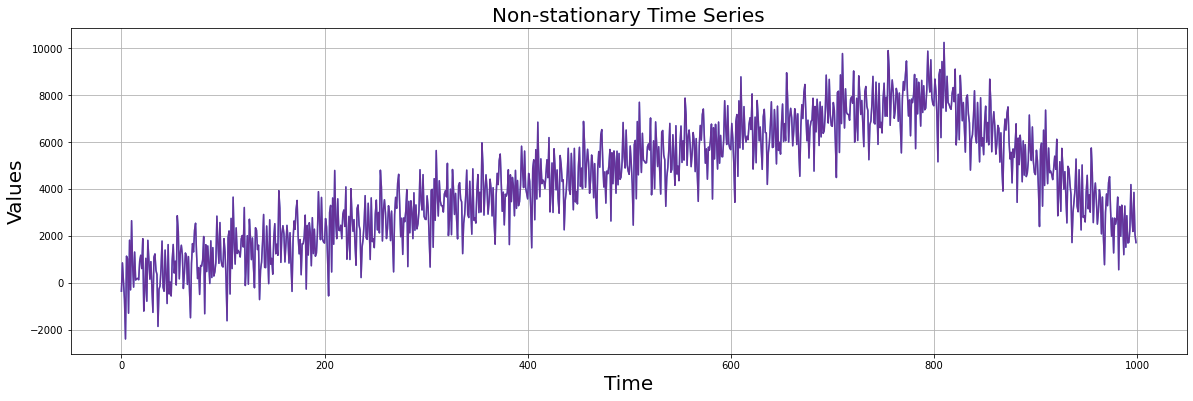

In [2]:
np.random.seed(6)

values = np.random.randn(200)*1000
seasonal = []
for i in range(10):   #10 seasons
    for j in range(100):
        seasonal.append(values[j])
        
noise = np.random.randn(1000)*100
seasonal += noise
seasonal_upward = seasonal + np.arange(1000)*10
big_event = np.zeros(1000)
big_event[-200:] = np.arange(200)*-40
non_stationary = seasonal_upward  + big_event
time = np.arange(1000)


# now get our synthetic data into a dataframe and set 
df = pd.DataFrame({'time': time,
                   'values': non_stationary})
df=df.set_index(['time'])

# and visualise it
plt.figure(figsize=(20,6))
plt.plot(time, non_stationary, color="cornflowerblue")
plt.plot(time, df['values'], color='rebeccapurple')
plt.xlabel("Time", fontsize=20)
plt.ylabel("Values", fontsize=20)
plt.title("Non-stationary Time Series", fontsize=20)
plt.grid(True)
    

In [3]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
series = df
values = df.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 100)  # change to 100
print('MAE: %.3f' % mae)


>expected=4611.0, predicted=6196.8
>expected=5646.5, predicted=5467.1
>expected=5190.6, predicted=5750.9
>expected=3944.4, predicted=5190.6
>expected=2396.3, predicted=4185.8
>expected=5696.1, predicted=5464.6
>expected=5948.4, predicted=5248.8
>expected=3261.7, predicted=2738.9
>expected=6504.3, predicted=6062.6
>expected=4146.2, predicted=4166.4
>expected=7359.4, predicted=6454.9
>expected=5300.3, predicted=5832.5
>expected=4222.8, predicted=3144.0
>expected=5741.9, predicted=6093.9
>expected=4694.8, predicted=5182.7
>expected=4760.5, predicted=4597.6
>expected=4618.3, predicted=4367.0
>expected=4396.6, predicted=5314.6
>expected=4912.8, predicted=4885.5
>expected=5394.5, predicted=4173.9
>expected=4837.3, predicted=5114.8
>expected=6116.2, predicted=5121.7
>expected=2853.8, predicted=4691.6
>expected=3873.4, predicted=4909.2
>expected=5157.7, predicted=5232.6
>expected=3043.0, predicted=4683.7
>expected=5727.9, predicted=5134.2
>expected=4932.8, predicted=4514.2
>expected=3984.4, pr

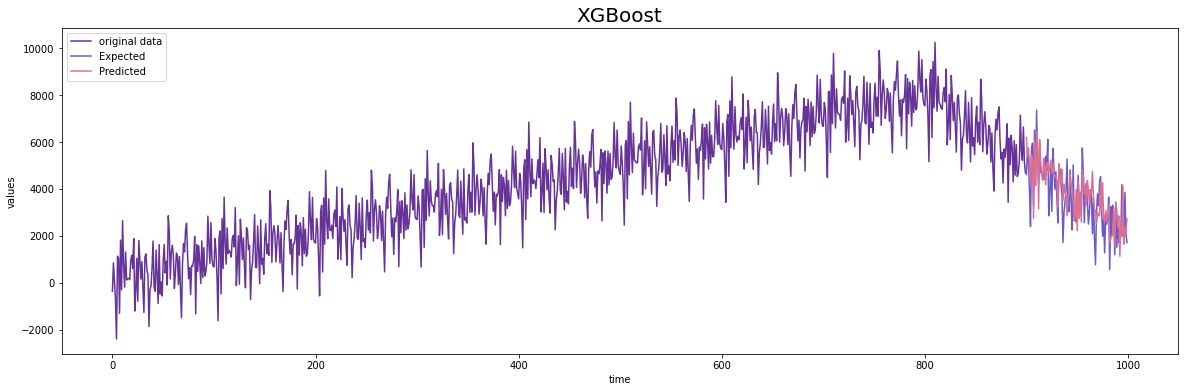

In [4]:
# plot expected vs preducted
plt.figure(figsize=(20,6))
plt.plot(time[:-100], values[:-100], color = "rebeccapurple", label='original data')
plt.plot(time[-100:], y, label='Expected', color='slateblue')
plt.plot(time[-100:], yhat, label='Predicted', color='palevioletred')
plt.title("XGBoost", fontsize=20)
plt.xlabel("time")
plt.ylabel("values")
plt.legend(loc="upper left")
plt.show()

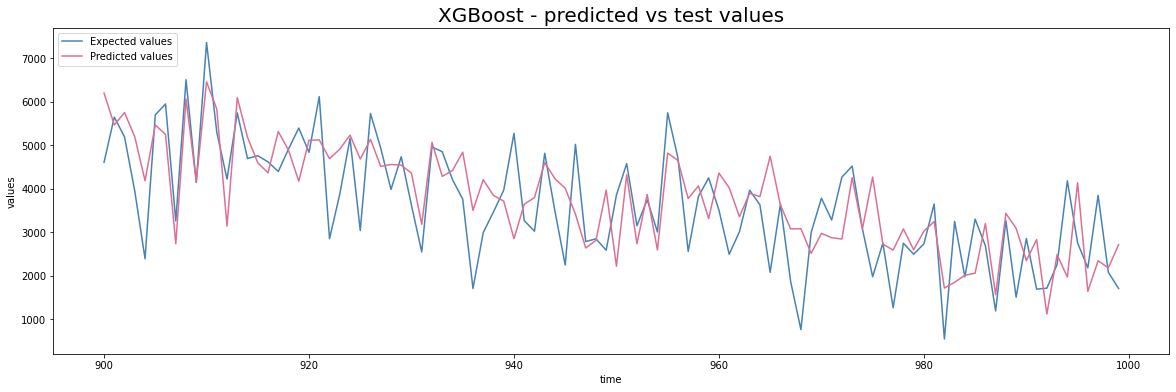

In [5]:
# plot expected vs preducted
plt.figure(figsize=(20,6))
# plt.plot(time[:-100], values[:-100], color = "rebeccapurple", label='original data')
plt.plot(time[-100:], y, label='Expected values', color='steelblue')
plt.plot(time[-100:], yhat, label='Predicted values', color='palevioletred')
plt.title("XGBoost - predicted vs test values", fontsize=20)
plt.xlabel("time")
plt.ylabel("values")
plt.legend(loc="upper left")
plt.show()

 ***


## LSTM
### see part III of this notebook
https://www.kaggle.com/werakaggle/time-series-forecasting-methods-part-iii-lstm



## part I is available here:
https://www.kaggle.com/code/werakaggle/time-series-forecasting-methods-part-i


 ***

 
**References:**


Jason Brownlee. Machine Learning Mastery. (2020). *How to Use XGBoost for Time Series Forecasting.* https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

See part I for full list of references.